In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

For simplify model and make it easier to calculate. We use these parameters.

In [148]:
# 设置参数
A_bar = 1.0      # 固定的生产力水平
theta = 0.5      # 资本的弹性
p = 1.0          # 资本商品的价格
gamma = 0.1      # 调整成本参数
beta = 0.95      # 折现因子



In [149]:
# 利润函数 Π(K)
def profit_function(K):
    return np.exp(A_bar) * (K ** theta)

# 成本函数 C(I, K)
def cost_function(I):
    I = np.clip(I, -1e10, 1e10)  # 限制 I 的范围，避免过大值
    return (gamma / 2) * (I ** 2)





The right-hand side expression of the Bellman equation represents the immediate payoff (or immediate return) from the current decision, plus the discounted value of future decisions. Mathematically, the Bellman equation can be written as:

$$
V(K_t) = \max_{I_t} \left[ \Pi(K_t) - p I_t - C(I_t, K_t) + \beta V(K_{t+1}) \right]
$$

Where:

- $\ V(K_t) $ is the value function given the capital level $\ K_t $, representing the maximum return starting from the current time \( t \) onward.
- $\ \Pi(K_t) $ is the profit of the firm given the capital $\ K_t $.
- $\ p I_t $ is the cost needed to purchase the investment $\ I_t $.
- $\ C(I_t, K_t) = \frac{\gamma}{2} I_t^2 $ is the adjustment cost of investment, which increases as investment increases.
- $ \beta $ is the discount factor, used to discount future returns to the present.
- $\ V(K_{t+1}) $ is the value function at the next period capital level $ K_{t+1} = K_t + I_t $.

The **right-hand side expression of the Bellman equation** is:

$$
\Pi(K_t) - p I_t - C(I_t, K_t) + \beta V(K_{t+1})
$$

This expression consists of two parts:

1. **Immediate Return**: The profit $ \Pi(K_t) $ at the current time $ t $, minus the investment cost $ p I_t $ and adjustment cost $ C(I_t, K_t) $.
2. **Discounted Future Value**: $ \beta V(K_{t+1}) $, which represents the future value at the next period capital $ K_{t+1} $, discounted by $ \beta $.

The core idea of the Bellman equation is **recursive optimality**, which means that the optimal decision at the current time should consider not only the current payoff but also the discounted value of future payoffs. Therefore, we need to find the value of $\ I_t $ that maximizes this expression.


In [150]:
# 贝尔曼方程的右侧表达式
# right-hand side expression of the Bellman equation
def bellman_rhs(K, I, V_next):
    return profit_function(K) - p * I - cost_function(I) + beta * V_next

编写贝尔曼方程的递归计算函数，该函数用来优化每一步的投资 $I t$，使价值函数最大化。

In [151]:
def bellman_equation(K, V_func):
    # 为 V_func 创建插值函数
    K_vals = np.array(list(V_func.keys()))
    V_vals = np.array(list(V_func.values()))
    V_interp = interp1d(K_vals, V_vals, fill_value="extrapolate")

    # 定义优化的目标函数
    def objective(I):
        K_next = K + I
        V_next = V_interp(K_next)  # 插值后的值
        return -bellman_rhs(K, I, V_next)  # 最大化时取负

    # 求解最优投资 I_t
    result = minimize(objective, x0=0.1, bounds=[(0, None)])
    if result.success:
        I_opt = result.x[0]
    else:
        I_opt = 0

    # 基于最优 I_opt 计算价值函数 V
    K_next = K + I_opt
    V_next = V_interp(K_next)
    V = bellman_rhs(K, I_opt, V_next)
    
    # 确保返回 V 和 I_opt
    return V, I_opt


边际 Q 是价值函数对资本的偏导数。我们将使用有限差分方法来数值计算边际 Q。

In [152]:
# 数值计算边际 Q
def marginal_q(K, V_func, delta=1e-5):
    # 使用有限差分方法计算边际 Q
    return (V_func(K + delta) - V_func(K)) / delta


通过迭代的方法逐步求解价值函数，直到收敛。这里我们采用一个近似的线性插值方法来更新价值函数。

In [153]:
# Initialize value function and policy function as dictionaries
value_function = {K: profit_function(K) / (1 - beta) for K in np.linspace(0.1, 2, 10)}
policy_function = {}

# Iterative computation of the value function
for iteration in range(100):
    new_value_function = {}
    new_policy_function = {}

    # Update value function and policy function for each capital level in the grid
    for K in np.linspace(0.1, 2, 10):
        V, I_opt = bellman_equation(K, value_function)  # Get both V and I_opt
        new_value_function[K] = V      # Store the value function result
        new_policy_function[K] = I_opt # Store the optimal investment (policy)

    # Check for convergence
    if all(abs(new_value_function[K] - value_function[K]) < 1e-4 for K in new_value_function):
        print(f"Converged after {iteration + 1} iterations")
        break

    # Update value function and policy function
    value_function = new_value_function
    policy_function = new_policy_function

# 输出结果
print("Value Function:")
for K, V in value_function.items():
    print(f"K = {K:.2f}, V = {V:.4f}")

print("\nPolicy Function (Optimal Investment):")
for K, I_opt in policy_function.items():
    print(f"K = {K:.2f}, I_opt = {I_opt:.4f}")


Value Function:
K = 0.10, V = 165118036.5761
K = 0.31, V = 165118035.8473
K = 0.52, V = 165118038.4687
K = 0.73, V = 165118038.6947
K = 0.94, V = 165118039.4064
K = 1.16, V = 165118039.8049
K = 1.37, V = 165118040.4316
K = 1.58, V = 165118041.1402
K = 1.79, V = 165118041.7818
K = 2.00, V = 165117700.5137

Policy Function (Optimal Investment):
K = 0.10, I_opt = 1.1000
K = 0.31, I_opt = 0.0000
K = 0.52, I_opt = 1.1000
K = 0.73, I_opt = 0.4277
K = 0.94, I_opt = 0.4315
K = 1.16, I_opt = 0.1021
K = 1.37, I_opt = 0.1000
K = 1.58, I_opt = 0.1006
K = 1.79, I_opt = 0.0000
K = 2.00, I_opt = 0.0000


Finally, we calculate the marginal Q at different capital levels and output the results.

In [154]:
# 计算不同资本水平下的边际 Q
# K_values = np.linspace(0.1, 2, 10)
# marginal_q_values = [marginal_q(K, value_function) for K in K_values]

# 打印边际 Q
for K, Q in value_function.items():
    print(f"The marginal Q at capital level K={K:.2f} is  Q={Q:.4f}")


The marginal Q at capital level K=0.10 is  Q=165118036.5761
The marginal Q at capital level K=0.31 is  Q=165118035.8473
The marginal Q at capital level K=0.52 is  Q=165118038.4687
The marginal Q at capital level K=0.73 is  Q=165118038.6947
The marginal Q at capital level K=0.94 is  Q=165118039.4064
The marginal Q at capital level K=1.16 is  Q=165118039.8049
The marginal Q at capital level K=1.37 is  Q=165118040.4316
The marginal Q at capital level K=1.58 is  Q=165118041.1402
The marginal Q at capital level K=1.79 is  Q=165118041.7818
The marginal Q at capital level K=2.00 is  Q=165117700.5137


如题，我们知道参数如下：

In [155]:
# use new parameters
beta = 0.95        # discount factor
theta = 0.7        # elasticity with respect to capital
gamma = 0.2        # adjustment cost parameter
p = 1.2            # price of capital goods
A_bar = 1.5        # fixed productivity level

In [156]:
# Define capital grid
K_grid = np.linspace(30, 80, 301)

In [157]:
# 初始化价值函数和策略函数
value_function = {K: profit_function(K) / (1 - beta) for K in K_grid}
policy_function = {}

In [158]:
# 迭代计算价值函数
for iteration in range(1000):
    new_value_function = {}
    new_policy_function = {}

    # 更新每个资本水平的价值函数和策略
    for K in K_grid:
        V, I_opt = bellman_equation(K, value_function)
        new_value_function[K] = V
        new_policy_function[K] = I_opt

    # 检查收敛性
    if all(abs(new_value_function[K] - value_function[K]) < 1e-4 for K in new_value_function):
        print(f"Converged after {iteration + 1} iterations")
        break

    # 更新价值函数和策略函数
    value_function = new_value_function
    policy_function = new_policy_function

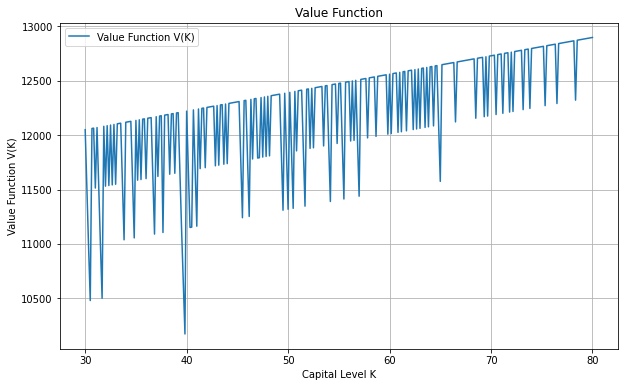

In [159]:
# 绘制价值函数
plt.figure(figsize=(10, 6))
plt.plot(K_grid, [value_function[K] for K in K_grid], label="Value Function V(K)")
plt.xlabel("Capital Level K")
plt.ylabel("Value Function V(K)")
plt.title("Value Function")
plt.legend()
plt.grid(True)
plt.show()



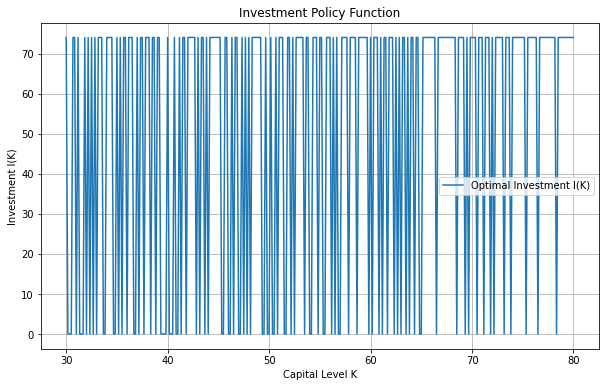

In [160]:
# 绘制投资策略函数
plt.figure(figsize=(10, 6))
plt.plot(K_grid, [policy_function[K] for K in K_grid], label="Optimal Investment I(K)")
plt.xlabel("Capital Level K")
plt.ylabel("Investment I(K)")
plt.title("Investment Policy Function")
plt.legend()
plt.grid(True)
plt.show()

延迟的贝尔曼方程

In [161]:
# 无延迟的贝尔曼方程
def bellman_equation_instant(K, V_func):
    K_vals = np.array(list(V_func.keys()))
    V_vals = np.array(list(V_func.values()))
    V_interp = interp1d(K_vals, V_vals, fill_value="extrapolate")

    def objective(I):
        K_next = K + I
        V_next = V_interp(K + I)  # 立即变成资本，无延迟
        return -profit_function(K + I) - cost_function(I)  # 无延迟的立即收益

    result = minimize(objective, x0=0.1, bounds=[(0, None)])
    I_opt = result.x[0] if result.success else 0
    K_next = K + I_opt
    V = profit_function(K_next) - cost_function(I_opt)
    return V, I_opt

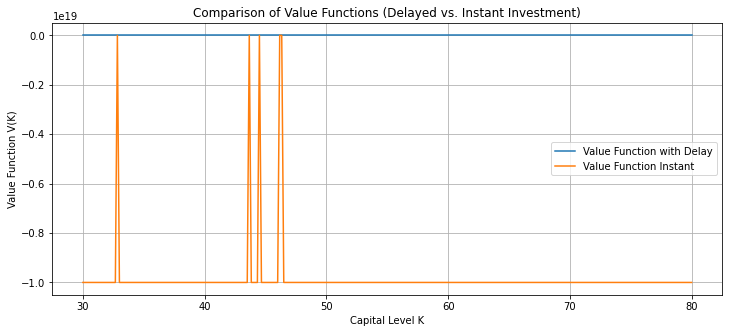

In [162]:
# 初始化价值函数
value_function_delayed = {K: profit_function(K) / (1 - beta) for K in K_grid}
value_function_instant = value_function_delayed.copy()
policy_function_delayed = {}
policy_function_instant = {}

# 迭代求解价值函数
for iteration in range(1000):
    new_value_function_delayed = {}
    new_value_function_instant = {}
    new_policy_function_delayed = {}
    new_policy_function_instant = {}

    for K in K_grid:
        V_delayed, I_opt_delayed = bellman_equation(K, value_function_delayed)
        new_value_function_delayed[K] = V_delayed
        new_policy_function_delayed[K] = I_opt_delayed

        V_instant, I_opt_instant = bellman_equation_instant(K, value_function_instant)
        new_value_function_instant[K] = V_instant
        new_policy_function_instant[K] = I_opt_instant

    if all(abs(new_value_function_delayed[K] - value_function_delayed[K]) < 1e-4 for K in K_grid) and \
       all(abs(new_value_function_instant[K] - value_function_instant[K]) < 1e-4 for K in K_grid):
        print(f"Converged after {iteration + 1} iterations")
        break

    value_function_delayed = new_value_function_delayed
    policy_function_delayed = new_policy_function_delayed
    value_function_instant = new_value_function_instant
    policy_function_instant = new_policy_function_instant

# 绘制价值函数的比较图
plt.figure(figsize=(12, 5))
plt.plot(K_grid, [value_function_delayed[K] for K in K_grid], label="Value Function with Delay")
plt.plot(K_grid, [value_function_instant[K] for K in K_grid], label="Value Function Instant")
plt.xlabel("Capital Level K")
plt.ylabel("Value Function V(K)")
plt.title("Comparison of Value Functions (Delayed vs. Instant Investment)")
plt.legend()
plt.grid(True)
plt.show()



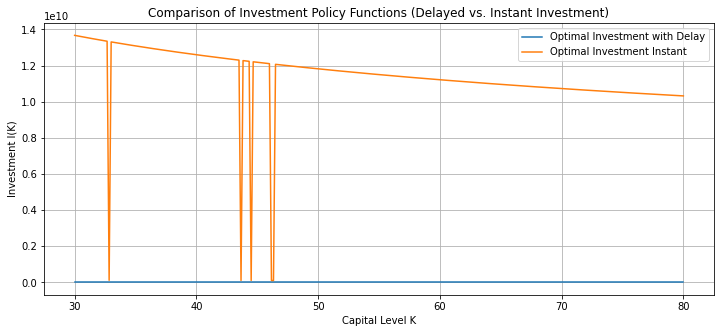

In [163]:
#绘制投资策略函数的比较图
plt.figure(figsize=(12, 5))
plt.plot(K_grid, [policy_function_delayed[K] for K in K_grid], label="Optimal Investment with Delay")
plt.plot(K_grid, [policy_function_instant[K] for K in K_grid], label="Optimal Investment Instant")
plt.xlabel("Capital Level K")
plt.ylabel("Investment I(K)")
plt.title("Comparison of Investment Policy Functions (Delayed vs. Instant Investment)")
plt.legend()
plt.grid(True)
plt.show()